In [4]:
import os, traceback
#os.chdir('../')
os.getcwd()

'C:\\Users\\Uzezi\\OneDrive\\Documents\\Anna_Plant_Phenotyping\\seed_pipeline_test'

In [ ]:
# This notebook is for running one analysis at a time and not for parallel processing.
# Parallel processing requires the python workflow and the json configuration file. 
# For future analysis; Open jupyter notebook from Anaconda and import or update packages using conda from Anaconda cmd prompt. Open Jupyter notebook in folder or directory containing seed scan images. 

In [5]:
%matplotlib inline

#Imports
import os, traceback
import scipy.signal
import argparse
import posixpath
import numpy as np
import copy
import cv2
from plantcv import plantcv as pcv 
from plantcv import parallel

def extractName(a):
    base=os.path.basename(a)
    return os.path.splitext(base)[0]

# The options class mimics the options function in a PlantCV workflow (mimics using argparse)
class options:
    def __init__(self):
        # Input image
        self.directory = "/mnt/c/Users/rossa/OneDrive - University of Massachusetts Boston/UMASS_Boston/rice/rice-phenotyping/Pheno_data/DS"
        self.image = "/mnt/c/Users/rossa/OneDrive - University of Massachusetts Boston/UMASS_Boston/rice/rice-phenotyping/Pheno_data/DS/12-02-2019_EpsonV600_019.jpg"
        # Debug = "plot" (Jupyter), "print" (file), or None
        self.debug = "plot"
        # Should we output analysis images from analyze_* functions
        self.writeimg = False
        # Name of results file
        self.result = extractName(self.image) + "_" + "result"



ModuleNotFoundError: No module named 'matplotlib'

In [3]:
print(pcv.__version__)

3.10.1


In [2]:
# This function has some functionality we need to deal with temporary results
# files when we want to analyze images with multiple objects
def multi_object_results(results_file):
	# If the results file exists (it will if we are running plantcv-workflow)
	if os.path.exists(results_file):
		# Load the data as JSON
		with open(results_file, "r") as f:
			metadata = json.load(f)
		# Delete the file, we will recreate it
		os.remove(results_file)
	else:
		# If the file does not exist we just need an empty metadata dictionary
		metadata = {"metadata": {}}
	
	prefix = results_file[:-4]
	return metadata, prefix


def create_object_results_file(metadata, prefix, object_id):
	filename = prefix + "_" + str(object_id) + ".txt"
	with open(filename, "w") as data:
		json.dump(metadata, data)
	return filename


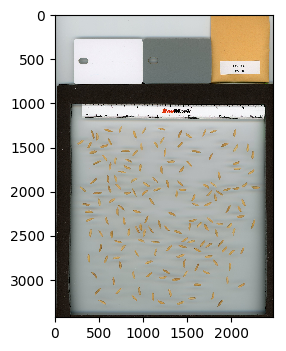

In [3]:
# Set global debug behavior to None (default), "print" (to file), 
# or "plot" (Jupyter Notebooks or X11)
#img = "../plantcv/tests/data/seed-image.jpg"
#pcv.params.debug = "plot"
#pcv.params.debug_outdir="seed-size-Oct16_2019/" #set output director

# Initialize instance of options called args to mimic the use of argparse in work flow script
args = options()
pcv.params.debug = args.debug

#let's save the args.directory so that we can go back anytime:
#originalDir = os.getcwd()

#read in image
img, imgpath, imgname = pcv.readimage(filename=args.image)
#img, path, img_filename = pcv.readimage(img, "native")

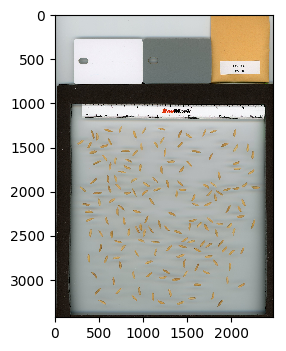

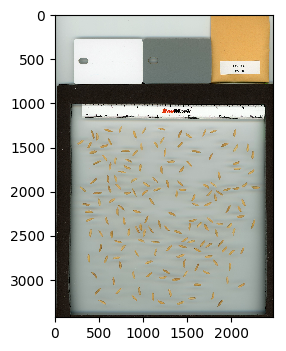

In [4]:
# STEP 2: Normalize the white color so you can later
# compare color between images.
# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(img, mode='hist', roi=(500, 500, 100, 100))

In [5]:
# Convert RGB to HSV and extract the Value channel
#img_gray_val = pcv.rgb2gray_hsv(img1, 'v')
#img_gray_val = 255 - img_gray_val

In [359]:
 # Converts RGB to HSV and extract the Saturation channel and inverts image
#img_gray_sat = pcv.rgb2gray_hsv(img1, 's')
#img_gray_sat = 255 - img_gray_sat

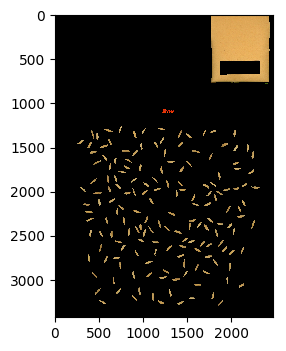

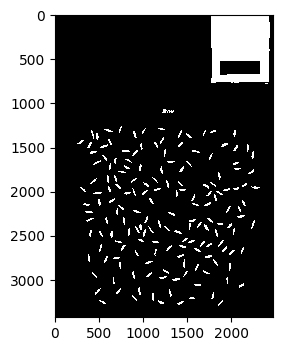

In [6]:
# Create masked image from a color image based LAB color-space and threshold values.
# for lower and upper_thresh list as: thresh = [L_thresh, A_thresh, B_thresh]

mask, masked_img = pcv.threshold.custom_range(rgb_img=img1, lower_thresh=[0,0,155], upper_thresh=[255,255,255], channel='LAB')

In [350]:
#Thresholds the Saturation image - 
#Creates a binary image from a gray image based on the threshold values. 
#The object target can be specified as dark or light

#sat_img_binary= pcv.threshold.triangle(img_gray_sat, 255,'dark', xstep=1)

In [323]:
#sat_img_binary = pcv.threshold.otsu(img_gray_sat, 255, object_type="dark")

In [343]:
# Threshold the Value image
#val_img_binary= pcv.threshold.triangle(img_gray_val, 255,'light', xstep=1)

In [344]:
#val_img_binary = pcv.threshold.otsu(img_gray_val, 255, object_type="dark")

In [335]:
# Combines masks
#img_binary = np.where(sat_img_binary < 255, val_img_binary, sat_img_binary)

In [336]:
# Fills in speckles smaller than 200 pixels
#mask = np.copy(img_binary)

In [346]:
#img_binary = pcv.threshold.triangle(masked_img, 255,'dark', xstep=1)

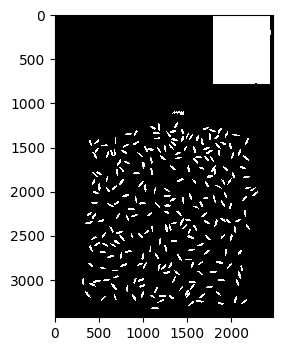

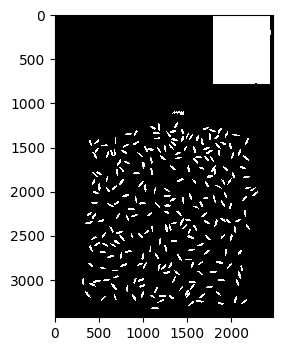

In [10]:
#Identifies objects and fills objects that are less than specified size
# Fill in holes and salt noise in the mask 
fill_image = pcv.fill_holes(mask)
fill_image = pcv.fill(fill_image, 100)                               

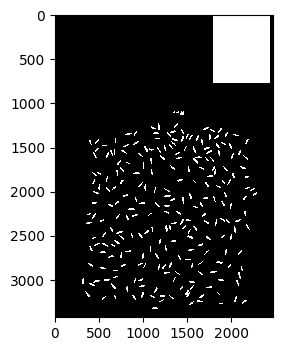

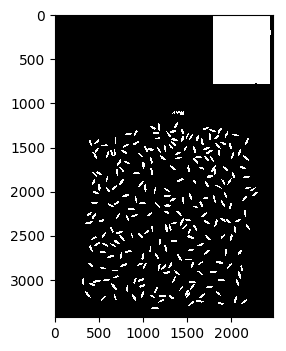

In [11]:
# Use erode and dilate to separate seeds that are close to one another
eroded_mask = pcv.erode(fill_image, ksize=5, i=1)
dil_mask = pcv.dilate(eroded_mask, ksize=5, i=1)

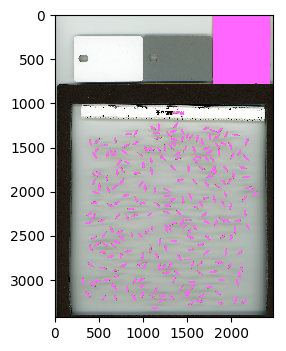

In [12]:
# Identifies objects using filled binary image as a mask
id_objects, obj_hierarchy = pcv.find_objects(img1, dil_mask)

In [127]:
#If you want to remove objects smaller than 100 pixels
# Make copy of the contours 
#id_objects2 = copy.copy(id_objects)

# Sort through and remove those specified 
#for i, seed in enumerate(id_objects):
#    if len(seed)<100:
#        id_objects2.remove(seed)
#        obj_hierarchy.remove(obj_hierarchy[i])

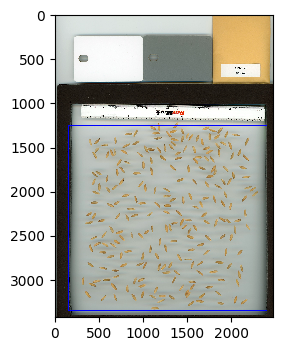

In [13]:
"""Defines rectangular ROI
the function pcv.define_roi doesn't exist anymore in the new PCV update. It has been replaced by
roi_contour, roi_hierarchy = plantcv.roi.circle(img, x, y, r)
roi_contour, roi_hierarchy = plantcv.roi.ellipse(img, x, y, r1, r2, angle)
roi_contour, roi_hierarchy = plantcv.roi.from_binary_image(img, bin_img)
roi_contour, roi_hierarchy = plantcv.roi.rectangle(img, x, y, h, w)

Parameters roi.rectangle:
img - An RGB or grayscale image to plot the ROI on in debug mode.
x - The x-coordinate of the upper left corner of the rectangle.
y - The y-coordinate of the upper left corner of the rectangle.
h - The height of the rectangle.
w - The width of the rectangle. 
"""

roi1, roi_hierarchy= pcv.roi.rectangle(img=img1, x=150, y=1250, h=2100, w=2250)

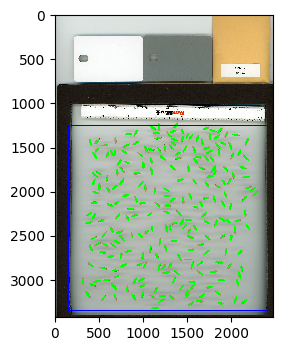

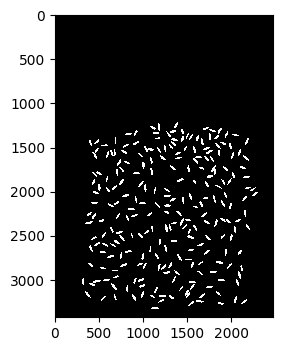

In [14]:
"""Keeps only objects within or partially within ROI
Find objects within a region of interest, 
either cut those objects to the region of interest or include objects that overlap with the region of interest
img = RGB or grayscale image data to display kept objects on
roi_contour = contour of roi, output from one of the pcv.roi subpackage functions
roi_hierarchy = contour of roi, output from one of the pcv.roi subpackage functions
object_contour = contours of objects, output from "find_objects" function
obj_hierarchy = hierarchy of objects, output from "find_objects" function
roi_type = 'partial' (for partially inside, default), 'cutto', or 'largest' (keep only the largest contour)
""" 


roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_contour=roi1, roi_hierarchy=roi_hierarchy, object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, roi_type='partial')

In [15]:
# Randomly colors the individual seeds
img_copy = np.copy(img1)
for i in range(0, len(roi_objects)):
    rand_color = pcv.color_palette(1)
    cv2.drawContours(img_copy, roi_objects, i, rand_color[0], -1, lineType=8, hierarchy=roi_obj_hierarchy)
image_name = extractName(args.image) + "_seedColors.jpg"
pcv.print_image(img_copy, image_name)#save the picture
pcv.outputs.clear()

In [17]:
#The result file should exist if plantcv-workflow.py was run
#if os.path.exists(args.result):
    # Open the result file
#    results = open(args.result, "r")
    # The result file would have image metadata in it from plantcv-workflow.py, read it into memory
#    metadata = results.read()
    # Close the file
#    results.close()
    # Delete the file, we will create new ones
#    os.remove(args.result)
#else:
    # If the file did not exist (for testing), initialize metadata as an empty string
#    metadata = "{}"

In [48]:
#create a folder in the work directory where to store the .json files
dir = extractName(args.image) + "_output_JOIN"
if not os.path.exists(dir):
    os.mkdir(dir)
os.chdir(dir)
os.getcwd()

'/mnt/c/Users/rossa/OneDrive/Desktop/Linux-amarrano/myNotebook/notebooks_scripts/01-22-2020_EpsonV600_018_output_JOIN'

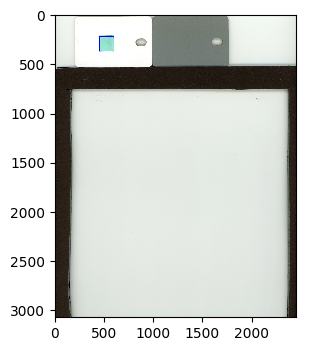

In [72]:
# Define an ROI for the marker
roi2, roi_hierarchy2 = pcv.roi.rectangle(img1, x=450, y=216, h=150, w=150)#square with l = 1 cm

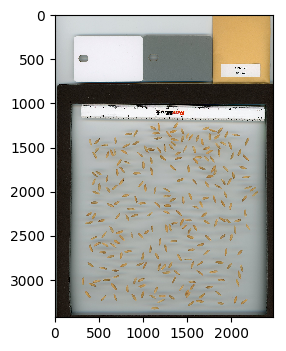

In [76]:
"""Detect and Measure Size Marker

Finds the area of the size marker in pixels and saves to "marker data"
Get and record the size of a size marker or set an area as a size marker (purple circle in the image)

Parameters:
img = An RGB or grayscale image to plot the marker object on
roi_contour = A region of interest contour (e.g. output from pcv.roi.rectangle or other methods)
roi_hierarchy = A region of interest contour hierarchy (e.g. output from pcv.roi.rectangle or other methods)
marker = 'define' (default) or 'detect'. If 'define' it means you set an area, if 'detect' it means you want to detect within an area
objcolor = Object color is 'dark' (default) or 'light' (is the marker darker or lighter than the background)
thresh_channel = 'h', 's', or 'v' for hue, saturation or value, default set to None
thresh = Binary threshold value (integer), default set to None.
""" 

image = pcv.report_size_marker_area(img, roi2, roi_hierarchy2, marker='detect', objcolor='dark', thresh_channel='s', thresh=120)

# Access data stored out from report_size_marker_area
marker_area = pcv.outputs.observations['marker_area']['value']
#    marker_name = extractName(args.image) + "_markerSize.json"
#    pcv.print_results(filename= marker_name)
pcv.outputs.clear()

metadata, prefix = multi_object_results(args.result)   

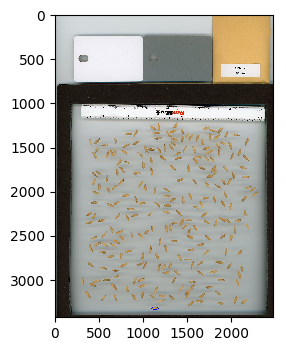

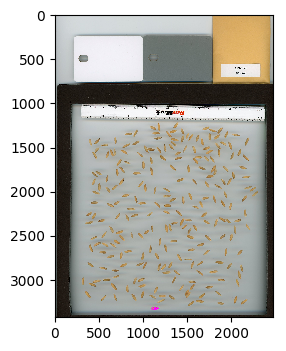

NameError: global name 'json' is not defined

In [77]:
# Gets the area of each seed, saved in analysis_image
for i in range(0, len(roi_objects)):
    if roi_obj_hierarchy[0][i][3] == -1:  # Checks if shape is a parent contour
                                           # roi_obj_hierarchy is a list of arrays - 
                                           #with this command they are selecting the third element of the 
                                           #i elements of the first (unique) array (0)

           # Object combine kept objects
        obj, mask2 = pcv.object_composition(img, [roi_objects[i]], np.array([[roi_obj_hierarchy[0][i]]]))
        
        if obj is not None:
            analysis_image = pcv.analyze_object(img, obj, mask2)
            pcv.outputs.add_observation(variable='marker_area', trait='marker area',
                            method='plantcv.plantcv.report_size_marker_area', scale='pixels', datatype=int,
                            value=marker_area, label='pixels')

            value = extractName(args.image) + "_S" + str(i)
               # Add custom output - save seed IDs:
            pcv.outputs.add_observation(variable='filename', trait='roi', method='roi',
                                        scale='int', datatype=int, value=value, label='#')
            
                       
               # At this point we have observations for one seed
               # We can write these out to a unique results file
               # Here I will name the results file with the ROI ID combined with the original result filename
            filename = create_object_results_file(metadata, prefix, i)
            pcv.print_results(filename=filename)
               # The results are saved, now clear out the observations so the next loop adds new ones for the next plant
            pcv.outputs.clear()

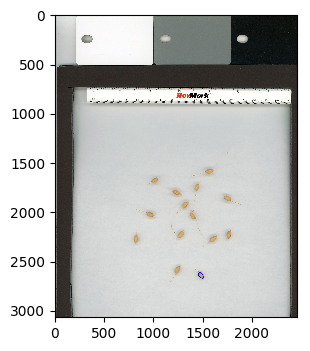

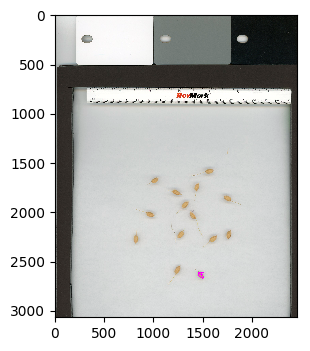

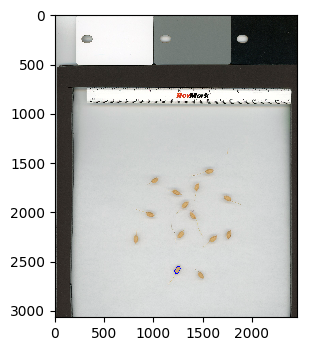

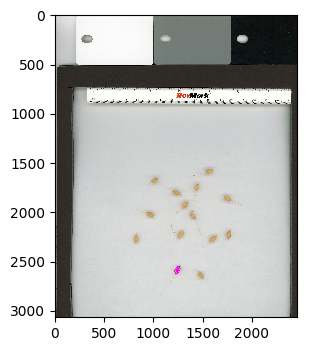

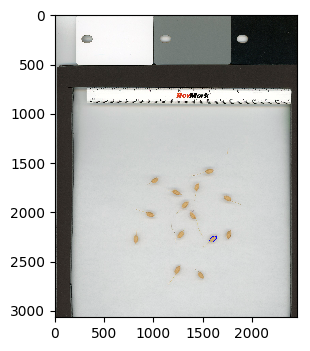

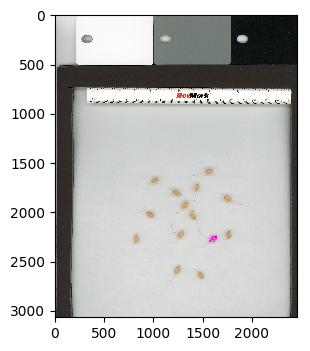

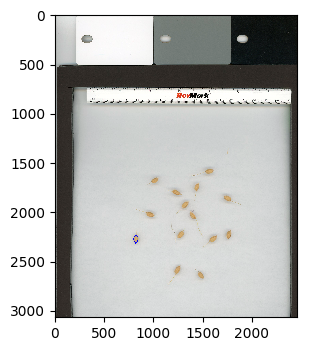

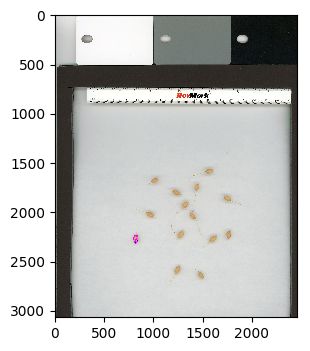

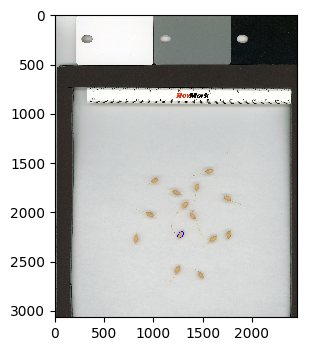

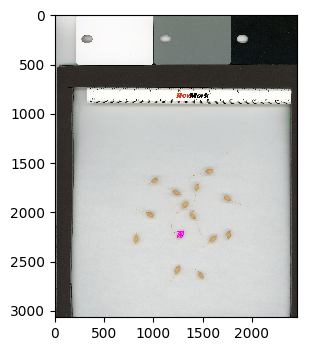

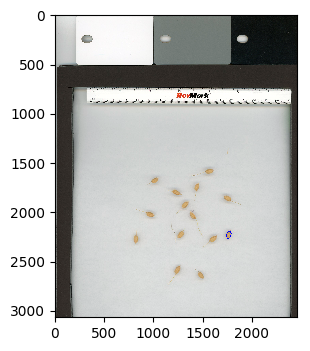

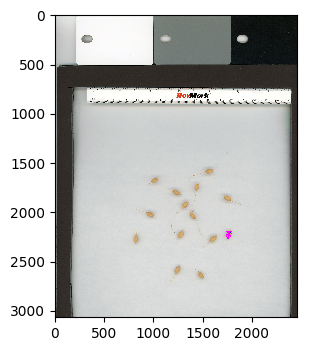

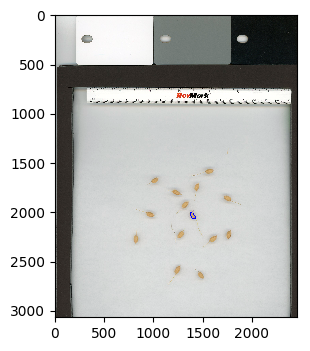

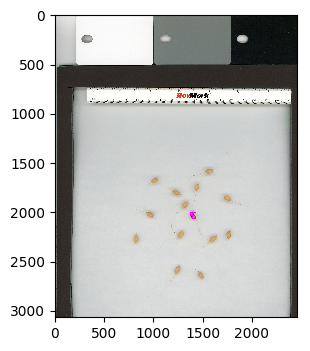

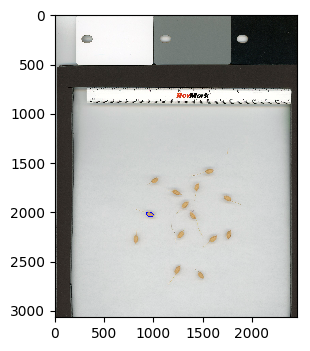

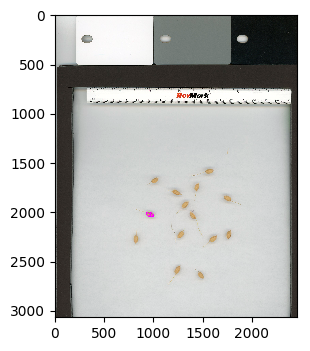

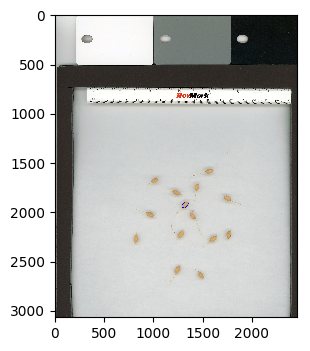

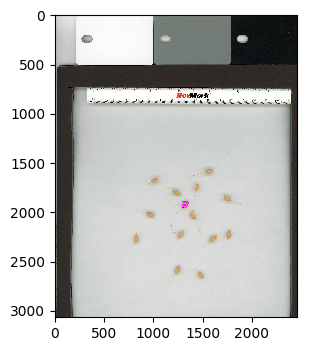

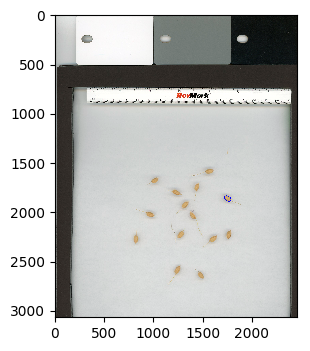

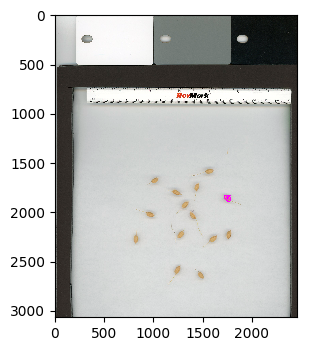

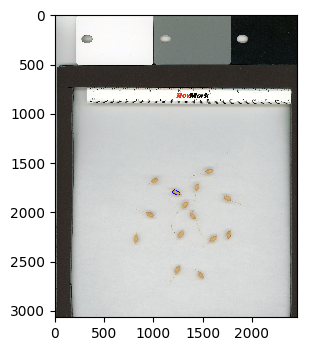

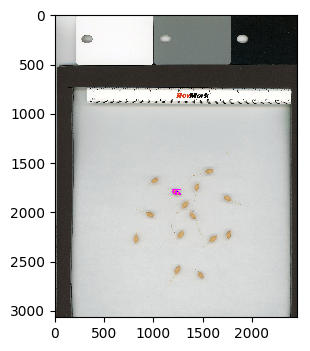

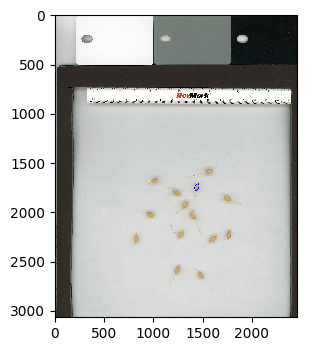

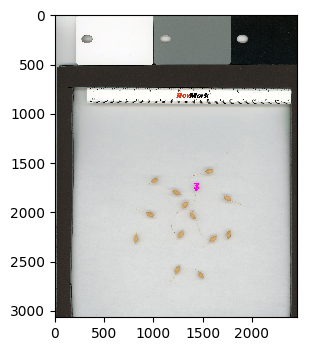

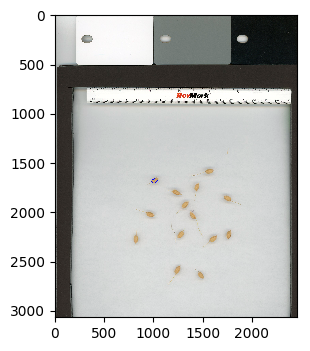

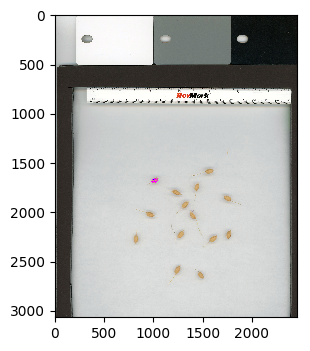

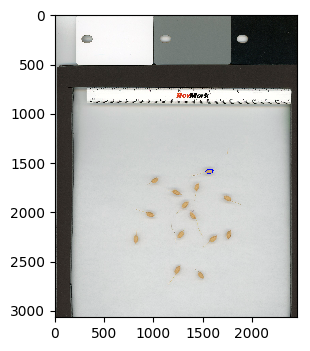

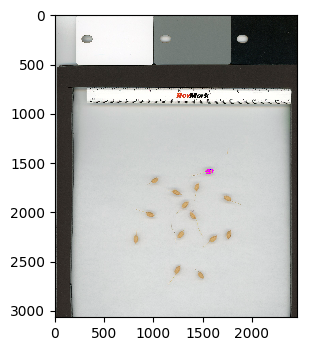

In [258]:
# Gets the area of each seed, saved in analysis_image
#for i in range(0, len(roi_objects)):
#    if roi_obj_hierarchy[0][i][3] == -1:  # Checks if shape is a parent contour
                                        # roi_obj_hierarchy is a list of arrays - 
                                        #with this command they are selecting the third element of the 
                                        #i elements of the first (unique) array (0)

        # Object combine kept objects
#        obj, mask2 = pcv.object_composition(img1, [roi_objects[i]], np.array([[roi_obj_hierarchy[0][i]]]))
        
#        if obj is not None:
#            analysis_image = pcv.analyze_object(img1, obj, mask2)
            
#            value = extractName(args.image) + "_S" + str(i)
            # Add custom output
#            pcv.outputs.add_observation(
#                    variable='filename',
#                    trait='roi',
#                    method='roi',
#                    scale='int',
#                    datatype=int,
#                    value=value,
#                    label='#')            
                       
            # At this point we have observations for one seed
            # We can write these out to a unique results file
            # Here I will name the results file with the ROI ID combined with the original result filename
            filename = extractName(args.image) + "_" + str(i) + ".json" 
            pcv.print_results(filename=filename)
            # The results are saved, now clear out the observations so the next loop adds new ones for the next plant
            pcv.outputs.clear()


In [260]:
#filename = extractName(args.image) + '_allSeeds.json'
#parallel.process_results(dir,filename)